# Machine Learning with Hyperparameter Optimization

[EuroSAT](https://zenodo.org/records/7711810#.ZAm3k-zMKEA) is a land use and land cover classification dataset based on Sentinel-2 imagery. It contains 27,000 labeled and geo-referenced 64X64 pixel images. The images cover the entire region of Europe. Each image has information covering 13 bands and belong to one of 10 labelled land use land cover classes. In this noteboook, we use the EuroSAT dataset to extract information from the images and use it to learn the processing of **supervised machine learning algorithms**.

### Creating the dataframe to use for machine learning

The following code imports required libraries for reading the data. 'rasterio' is used to read image data.

In [69]:
import os
from os.path import isfile, join

from time import time

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
import rasterio.features
import rasterio.warp
import geojson

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import shapely.geometry


In [2]:
import warnings
warnings.filterwarnings('ignore')
# ignoring warnings to keep the jyupter notebook clutter free

In [3]:
directory_path = '/data/shared/Big-Geodata-Processing-2023-1A/Exercise3/EuroSAT_MS/'

The function get_all() extracts all details of the image by reading the each image only once. We extract statistical values like mean, median, min, max, range of selected bands. The bands selected are blue, green, red, nir and swir2. These bands have been selected as the wavelengths have significant difference in reflectance among the landcover classes.

Apart from this, we calculate 4 indices for each image (https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/). These indices are selected based on the 10 landuse classes in the EuroSAT dataset. The indices chosen are:
- NDVI - Normalised Difference Vegetation Index - for highlighting dense vegetation, forested areas
- SAVI - Soil Adjusted Vegetation Index - with an L factor of 0.5 for highlighting medium to sparse vegetation like grasslands and agriculture land
- NDBI - Normalised Difference Built-up Index - for highlighting built and artificial surfaces
- NDWI - Normalised Difference Water Index - for highlighting water surfaces

The median of calculated indices was selected per image. After looking at a couple of images in QGIS we chose median over mean as we want the indices value of manjority LULC of the image.

In [4]:
# function to get all details of the image by reading the each image only once

def get_all(filename):
    with rasterio.open(filename) as dataset:

        # CENTROID
        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'EPSG:4326', geom, precision=6)
            ls = list(geojson.utils.coords(geom))
            x = []
            y = []
            for row in ls:
                x.append(row[0])
                y.append(row[1])
            cent = [min(y)+(max(y)-min(y))/2,min(x)+(max(x)-min(x))/2]

        # BAND STATS 
        # Selected bands are R, G, B, NIR, SWIR2 to reduce dimentionality and avoid overfitting

        band_mean = []
        band_median = []
        band_min = []
        band_max = []
        band_range = []

        bands_selected = [2,3,4,8,13]
        for band in bands_selected:
            band_values = dataset.read(band).astype('float64')
            band_mean.append(round(np.mean(band_values), 4))
            band_median.append(round(np.median(band_values), 4))
            b_min = np.min(band_values)
            b_max = np.max(band_values)
            band_min.append(round(b_min, 4))
            band_max.append(round(b_max, 4))
            band_range.append(round((b_max - b_min), 4))


        # BAND INDICES
        # https://ieeexplore.ieee.org/abstract/document/8736785
        # The median values of calculated indices are used.
        # Choosing median over mean as we want the indices value of manjority of the image.
        # indices choosen based on available classes

        indices = []

        b_green = dataset.read(3).astype('float64')
        b_red = dataset.read(4).astype('float64')
        b_nir = dataset.read(8).astype('float64')
        b_swir2 = dataset.read(13).astype('float64')

        np.seterr(divide='ignore', invalid='ignore')

        # NDVI and SAVI for forested and crop area (L = 0.5 corresponding to moderate canopy)
        b_ndvi = (b_nir - b_red) / (b_nir + b_red)
        b_savi = ((b_nir - b_red) / (b_nir + b_red + 0.5))*(1.5)
        indices.append(round(np.median(b_ndvi), 4))
        indices.append(round(np.median(b_savi), 4))

        # NDWI for water related classes
        b_ndwi = (b_green - b_nir) / (b_green + b_nir)
        indices.append(round(np.median(b_ndwi), 4))

        # NDBI for built up surfaces
        b_ndbi = (b_swir2 - b_nir) / (b_swir2 + b_nir)
        indices.append(round(np.median(b_ndbi), 4))


    return cent, band_mean, band_median, band_min, band_max, band_range, indices

In [5]:
subfolders = [ f.path for f in os.scandir(directory_path) if f.is_dir() ]

The following code constructs a dataframe by iterating through the file path of all images. As there are 27000 images, this code takes about 4 min to run.

In [6]:
%%time

df = pd.DataFrame(columns=["Lat", "Lon", "Class"])
bands_selected = [2,3,4,8,13]
# Selected bands are R, G, B, NIR, SWIR2 to reduce dimentionality and avoid overfitting

for i in range(len(subfolders)):
    image_path = subfolders[i]
    class_name = os.path.basename(image_path)
    all_images = [f for f in os.listdir(image_path) if os.path.isfile(join(image_path, f))]
    print(class_name,len(all_images))
    for j in range(len(all_images)):
        cent, band_mean, band_median, band_min, band_max, band_range, indices  = get_all(image_path+'/'+all_images[j])

        new_row = pd.DataFrame({
            "Lat": cent[0], 
            "Lon": cent[1], 
            "Class": class_name,
            **{f"Band_{value}_mean": band_mean[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_median": band_median[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_min": band_min[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_max": band_max[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_range": band_range[k] for k, value in enumerate(bands_selected)},
            "I_NDVI_median": indices[0],
            "I_SAVI_median": indices[1],
            "I_NDWI_median": indices[2],
            "I_NDBI_median": indices[3]
        }, index=[0])
        df = pd.concat([df, new_row], ignore_index=True)


Residential 3000
Pasture 2000
SeaLake 3000
HerbaceousVegetation 3000
Forest 3000
Industrial 2500
River 2500
PermanentCrop 2500
AnnualCrop 3000
Highway 2500
CPU times: user 3min 22s, sys: 25 s, total: 3min 47s
Wall time: 4min 34s


From the above printed values, it can be noted that all classes of LULC have 2500 - 3000 points. This almost even distribution among classes is helpful for training the machine learning model in an unbiased manner.

In [7]:
df

,Lat,Lon,Class,Band_2_mean,Band_3_mean,Band_4_mean,Band_8_mean,Band_13_mean,Band_2_median,Band_3_median,...,Band_13_max,Band_2_range,Band_3_range,Band_4_range,Band_8_range,Band_13_range,I_NDVI_median,I_SAVI_median,I_NDWI_median,I_NDBI_median
0,51.636699,0.409756,Residential,1087.1743,901.1694,791.6636,1622.4224,1809.6243,1074.0,891.0,...,4075.0,1052.0,1565.0,2572.0,3399.0,2876.0,0.3176,0.4763,-0.2604,0.0612
1,43.677658,7.113914,Residential,1166.1226,1116.6089,1046.3782,2491.4802,2831.2668,1122.0,1067.0,...,3865.0,1735.0,2244.0,2896.0,3360.0,1878.0,0.4197,0.6295,-0.3880,0.0649
2,51.630671,-0.732539,Residential,1051.7507,984.2322,836.3401,2382.4775,2706.3179,1043.0,977.0,...,4424.0,1490.0,1336.0,1919.0,3853.0,2774.0,0.4403,0.6603,-0.3857,0.0703
3,52.333434,8.017260,Residential,1042.3748,868.2256,780.4990,1833.2454,2098.9531,1030.0,861.0,...,4799.0,1066.0,1108.0,1545.0,4247.0,3468.0,0.3547,0.5320,-0.3091,0.0697
4,43.730154,7.160103,Residential,1042.5291,970.1846,869.0532,2418.7869,2736.0049,975.0,894.0,...,3738.0,4882.0,5107.0,5396.0,9647.0,1981.0,0.5014,0.7520,-0.4478,0.0620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,49.216428,16.408736,Highway,1181.4778,1205.3447,1209.0364,2599.4766,2952.5251,1036.0,1140.0,...,3882.0,3825.0,3992.0,4717.0,4028.0,2065.0,0.4394,0.6590,-0.4206,0.0701
26996,49.082481,2.728486,Highway,1367.1580,1380.7993,1751.2991,2728.2957,3272.2312,1396.0,1438.0,...,3684.0,1609.0,1622.0,2100.0,2231.0,1881.0,0.2012,0.3017,-0.3286,0.0928
26997,37.763857,-3.719099,Highway,1755.2141,1903.7380,2208.5732,3079.9624,3461.2805,1745.0,1895.5,...,4453.0,1469.0,1859.0,2414.0,2709.0,2363.0,0.1638,0.2457,-0.2395,0.0570
26998,50.744405,4.544050,Highway,1004.7075,952.9724,816.0300,2661.9939,3059.2334,994.0,957.0,...,5095.0,866.0,1159.0,1542.0,3627.0,3335.0,0.5813,0.8719,-0.4855,0.0682


Managing null values before machine learning.

In [8]:
if df.isna().any().any():
    print("The DataFrame contains null values.")
else:
    print("The DataFrame does not contain null values.")

The DataFrame contains null values.


In [9]:
# Checking which columns have null
null_counts = df.isna().sum()
# null_counts

In [10]:
## Cheacking which rows have null
rows_with_null = df[df.isna().any(axis=1)].index
rows_with_null

Int64Index([656], dtype='int64')

In [14]:
# df.iloc[656]

In [11]:
# Manually calculating one null value with band median values

row_index = 656
df.at[row_index, 'I_NDVI_median'] = ((df.at[row_index, 'Band_8_median'] - df.at[row_index, 'Band_4_median']) / 
                                     (df.at[row_index, 'Band_8_median'] + df.at[row_index, 'Band_4_median']))

In [12]:
if df.isna().any().any():
    print("The DataFrame contains null values.")
else:
    print("The DataFrame does not contain null values.")

The DataFrame does not contain null values.


The DataFrame can now be used for training maching learning model with selected features.

### Visualising image points with folium

In [13]:
llc = ['Lat', 'Lon', 'Class']

# Keep only the required columns
df_llc = df[llc].copy()

In [14]:
gdf_ImageCentroids = gpd.GeoDataFrame(
    df_llc,
    geometry=gpd.points_from_xy(df_llc['Lon'], df_llc['Lat']),
    crs='EPSG:4326'
)

# gdf_ImageCentroids

gdf_ImageCentroids_random5000 = gdf_ImageCentroids.sample(n=5000, random_state=42)
# randomly sampling 5000 rows to plot using folium

In [15]:
gdf_ImageCentroids_random5000.explore(column = 'Class',zoom_start=3.5)

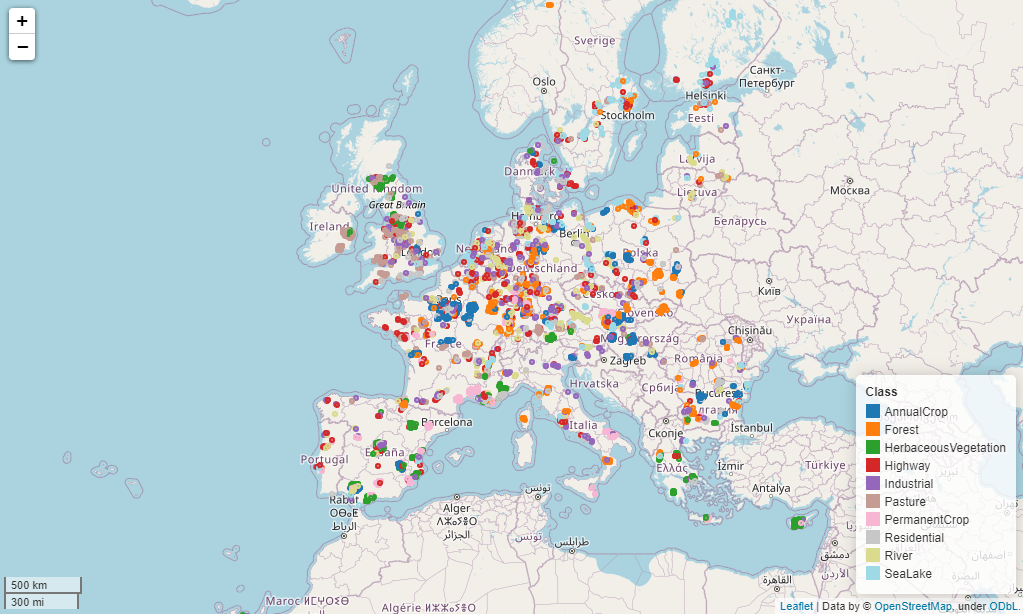

From the above visualisation it can be seen that all the image points are in the continent of Europe. All classes have an almost even distribution of image points which is helpful for training the machine learning model in an unbiased manner.

## Machine Learning using Random Forest

Random Forest (RF) is a decision tree based classifier that is well used for categorical data such as LULC. With appropriate hyper parameter tuning RF is a tested to be a reliable classifier(https://www.mdpi.com/2072-4292/11/8/907) that can be less computationally intensive than Neural Networks.

RF algorithm also allows user to analyse feature importance of the dataset. This is key when using multi-dimensional data like image bands. Selected features can later be used for exploring the best classifier model.

The following code imports required libraries for Random Forest classifier from sci-kit learn.

In [84]:
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

### Selecting relevant features & preparing dataframe

As scikit-learn Random Forest Classifier can handle upto 32 categorical variables, the y lables need not be encoded. This one-hot(using 0s and 1s) encoding is done internally. For other classifiers, encoding is mostly required.

As Random Forest Classifier is a decision tree based classifier, scaling the features may not really help the model. For linear algebra based classifiers, scaling features to a common range would surely help.

The following code splits the DataFrame into features and labels. Two dfs are created, with and without calculated Indices.

In [72]:
# Split the DataFrame into features and labels

X = df.drop(columns=["Class","Lat","Lon"])
# We do not need Lat and Lon values for non-geospatial machine learning model

columns_to_drop = [col for col in df.columns if col.startswith('I_')]
X_withoutIndices = df.drop(columns=["Class", "Lat", "Lon"] + columns_to_drop)
# Drop indices columns from the DataFrame to test

y = df["Class"]

y_withoutIndices = df["Class"]

### Splitting data for training & testing

As we originally have 27000 samples, we decided to split traning and testing as 70% and 30%. By not taking too many training samples, we try to limit overfitting the model. Using a 70:30 ratio, the estimated parameters will have reasonable variance. Apart from this, as we use a search hyper parameter tuning, having a large training set will increase the computational load.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=121)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_withoutIndices, y_withoutIndices, test_size=0.3, random_state=121)

# y_train

In [74]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (18900, 29)
Training Labels Shape: (18900,)
Testing Features Shape: (8100, 29)
Testing Labels Shape: (8100,)


### Building basic RF without indices

To test if including calculated indices make a change in the accuracy of the model, we train two basic default parameter models and compare the accuracy.

In [75]:
# Initialize the RF classifier
rfw_classifier = RandomForestClassifier(random_state=121)

# Train the classifier on the training data without indices
rfw_classifier.fit(Xw_train, yw_train)

# rfw_classifier

RandomForestClassifier(random_state=121)

In [76]:
# Predection
yw_pred = rfw_classifier.predict(Xw_test)

accuracy = accuracy_score(yw_test, yw_pred) # normalize=False

print(f"Accuracy of 'X_withoutIndices' : {accuracy:.4f}")

Accuracy of 'X_withoutIndices' : 0.8395


### Building basic RF with indices

In [77]:
%%time

# Testing RF classifier with all features including indices
rf_classifier = RandomForestClassifier(random_state=121)

# Train the classifier on the training data without indices
rf_classifier.fit(X_train, y_train)

CPU times: user 6.82 s, sys: 8.04 ms, total: 6.83 s
Wall time: 6.83 s


RandomForestClassifier(random_state=121)

In [78]:
%%time

# Predection
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of 'X' with all features: {accuracy:.4f} \n")

Accuracy of 'X' with all features: 0.8568 

CPU times: user 143 ms, sys: 3.97 ms, total: 147 ms
Wall time: 146 ms


As observed above,there is a slight increase in accuracy from 0.839 to 0.856 after including the calculated indices. Hence, going forward the dataset contains all features extracted from the images in EuroSAT.

### Using confusion matrix & feature importance to understand the results

In [79]:
# Generate a classification report
classification_rep = classification_report(y_test, y_pred)
print("\t \t \t Classification Report:\n \n", classification_rep)

	 	 	 Classification Report:
 
                       precision    recall  f1-score   support

          AnnualCrop       0.89      0.87      0.88       896
              Forest       0.97      0.98      0.97       900
HerbaceousVegetation       0.86      0.86      0.86       893
             Highway       0.66      0.48      0.56       756
          Industrial       0.86      0.92      0.89       790
             Pasture       0.84      0.82      0.83       607
       PermanentCrop       0.76      0.82      0.79       699
         Residential       0.78      0.84      0.81       905
               River       0.87      0.91      0.89       752
             SeaLake       0.99      0.99      0.99       902

            accuracy                           0.86      8100
           macro avg       0.85      0.85      0.85      8100
        weighted avg       0.85      0.86      0.85      8100



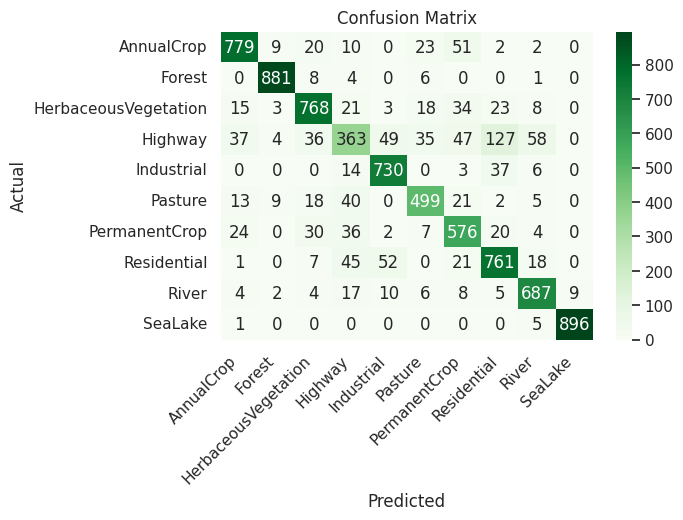

In [80]:
conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", conf_matrix)

class_names = sorted(df['Class'].unique())

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.savefig('confusion_matrix_Comb1.png', bbox_inches='tight')
plt.show()

The above classification report and matrix helps in understanding the accuracy of each class. Some classes like Forest and SeaLake have a high f-1 score, indicating that the classes are well classified. Highway class has an f-1 score of only 0.56, this is the least. Maybe including the NDBI (Built-up index did not help in this). Vegetation related classes have been classified well.

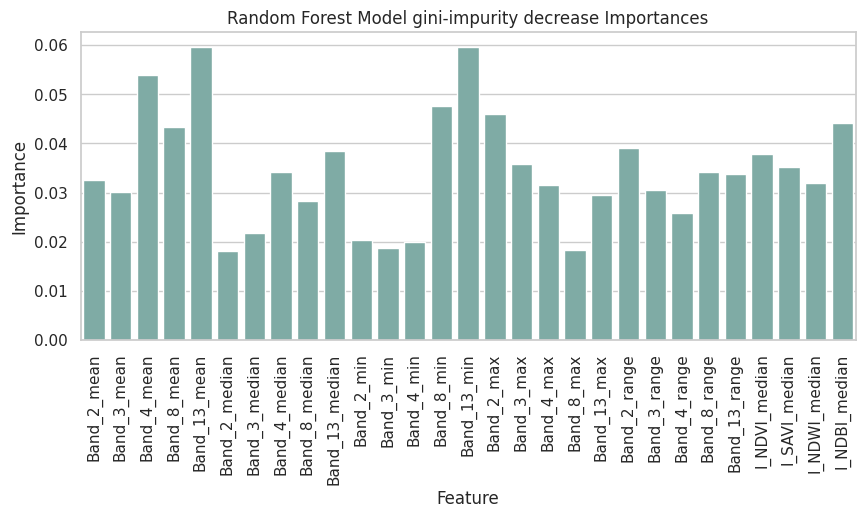

In [81]:
impurityDec_importances = rf_classifier.feature_importances_

feature_names = X.columns

impurityDec_importances_df = pd.DataFrame({"Feature": feature_names, "Importance": impurityDec_importances})

sns.set(style="whitegrid")

# Create a Seaborn bar plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x="Feature", y="Importance", data=impurityDec_importances_df, color="#78b2ab")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Model gini-impurity decrease Importances")
plt.xticks(rotation=90)

# Show the plot
plt.show()

The RF classifier uses gini-impurity as a metric to build decision trees. This assigns an importance metric to each feature that can be used for making a decision split. The higher decrease in gini-impurity, more important the feature. This is plotted above, it shows Band mean, min, max have relatively high importance.

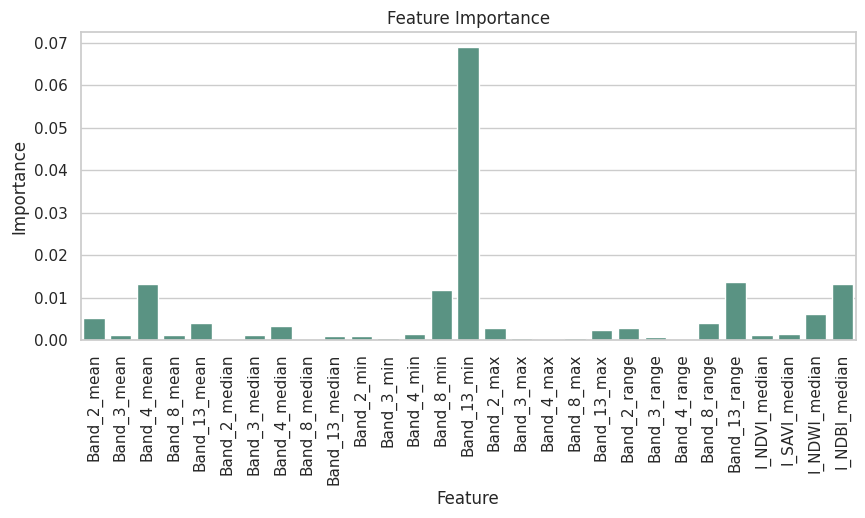

CPU times: user 42.7 s, sys: 116 ms, total: 42.8 s
Wall time: 42.6 s


In [82]:
%%time

result = permutation_importance(rf_classifier, X_train, y_train, random_state=121)

importances = result.importances_mean

feature_names = X_train.columns

feature_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})

sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 4))
sns.barplot(x="Feature", y="Importance", data=feature_importances, color="#509c87")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

Another more appropriate way to measure feature importance is by using permutation importance. This runs the tuned classifier in a loop, where in each iteration, one feature values are mixed randomly. The function then calculate the decreased accuracy due to this mixed data from one feature. If the decrease is high the more important the feature.

In the above graph, Band 13 min shows highest importance, this maybe due to how the SWIR wavelength differentiates water from non-water pixels. Apart from that, some other bands and indices also show high importance.

Note: as this function runs the classifier many times in a loop, it take extra time.

### Hyper Parameter Optimization

Till now, we have been using only a basic default RF model. Though this gives good results, we can explore combinations of different parameters to achieve a better result.

In [43]:
depth = [est.get_depth() for est in rf_classifier.estimators_[:15]]
depth

[33, 28, 32, 35, 28, 31, 28, 31, 27, 29, 28, 32, 30, 32, 30]

The above code shows that the default RF model is building trees of more than 25 in depth. This could surely overfit the model giving low accuracy on the testing sample. Overfitting means that the model becomes too bespoke to the training data and may not generalise well to new and unseen data. By controlling parameters like max-depth we could try to achieve better accuracy.

In the following code, we use a random search for hyper parameter tuning on the list of optional parameters. Ideally, a grid search tuning is a better way to go but as this was taking more than 7 hrs of wall time, we have used randomized search. The parameters tuned are:

- n_estimators: This gives the number of decision trees used in the RF model. Initially, more the number of trees, a better result can be expected. This is because the RF model votes for the highest majority among decision trees. However after a certain number, the accuracy plateaus with additional increase in trees.
- max_depth: This determines the depth of the RF trees in the model. Having too much depth can overfit the model
- min_samples_split: It gives the number of minimum sample examples to consider before a split in the tree. This relates to max_depth.
- criterion: This calculates tree evaluation based on gigi-impurity or entropy in the classified samples.
- max_features: This allows user to specify the number of features to be included in building the model. Too many features can overfit, too few can underfit.
- bootstrap: RF model randomly selects some examples to train each tree with bootstrapping. This is set to true.
- oob_score: While bootstrapping, out of bag samples are used to test accuracy of each tree. This is set to true.

In [95]:
%%time

# Define a range of hyperparameter values to search
param_dist = {
    'n_estimators': [70, 100, 250],
    'max_depth': [8, 12, 18],
    'min_samples_split': [5, 10],
    'criterion': ["gini", "entropy"],
    'max_features': [20, None],
    'bootstrap': [True],
    'oob_score': [True]
}

n_iter_search = 10

# Initialize the RandomSearchCV object
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=121),
                           param_distributions=param_dist,
                           n_iter=n_iter_search,
                           cv=5,  # Number of cross-validation folds splits training data further into train and test
                           scoring='accuracy'
                           )

start = time()
# Perform the grid search on the training data
random_search.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# Get the best hyperparameters from the search
best_score = random_search.best_score_
print("Best accuracy: ", best_score, "\n \n")

best_params = random_search.best_params_
print("Best Hyperparameters: ", best_params, "\n \n")

RandomizedSearchCV took 2546.13 seconds for 10 candidates parameter settings.
Best accuracy:  0.8517989417989419 
 

Best Hyperparameters:  {'oob_score': True, 'n_estimators': 100, 'min_samples_split': 5, 'max_features': 20, 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': True} 
 

CPU times: user 42min 18s, sys: 99 ms, total: 42min 19s
Wall time: 42min 26s


In [96]:
# Re-train the model with the best hyperparameters
best_rf_classifier = random_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Make predictions using the optimized model
y_pred_optimized = best_rf_classifier.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy of 'X' with all features after grid search: {grid_accuracy:.4f} \n")

Accuracy of 'X' with all features after grid search: 0.8581 



RandomizedSearchCV resulted in best paramaters - 70 trees, max_features 20 out of 29 available, max_depth 18 much less than the initial basic model.

However, the overall test accuracy of the model did not change much.

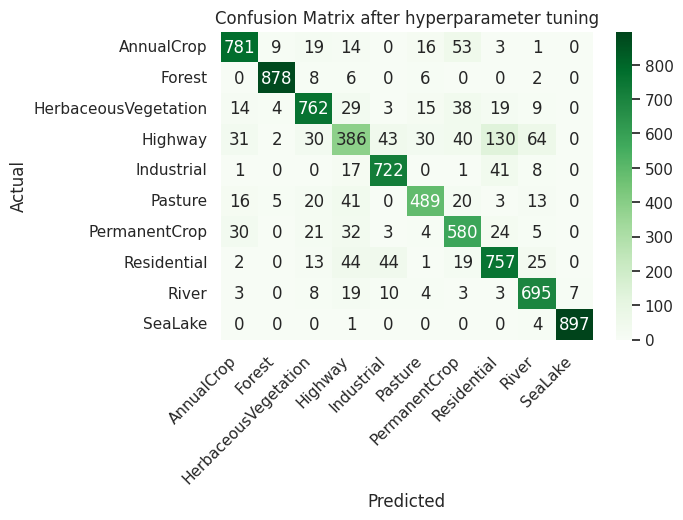

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
# print("Confusion Matrix:\n", conf_matrix)

class_names = sorted(df['Class'].unique())

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after hyperparameter tuning')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.savefig('confusion_matrix_Comb2.png', bbox_inches='tight')
plt.show()

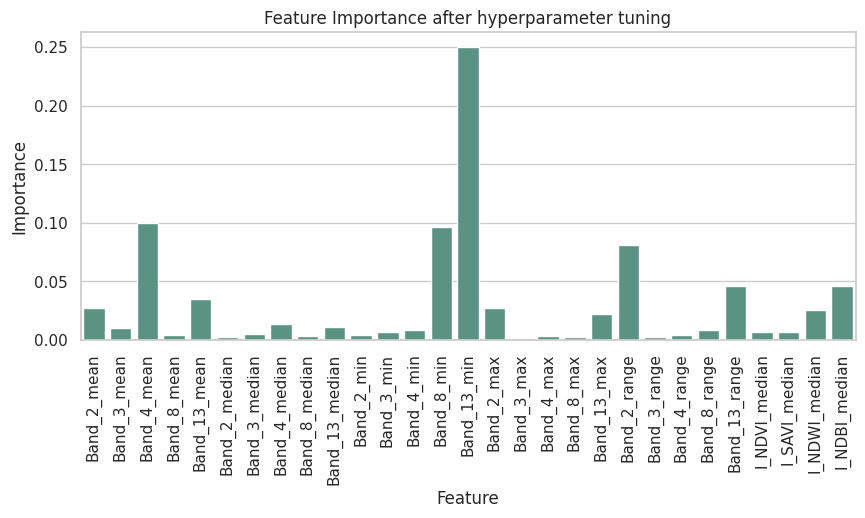

CPU times: user 27.3 s, sys: 92 ms, total: 27.4 s
Wall time: 27.3 s


In [93]:
%%time

result = permutation_importance(best_rf_classifier, X_train, y_train, random_state=121)

importances = result.importances_mean

feature_names = X_train.columns

feature_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})

sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 4))
sns.barplot(x="Feature", y="Importance", data=feature_importances, color="#509c87")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importance after hyperparameter tuning")
plt.show()

The feature importance ranges seem similar to the one earlier.

As RandomizedSearchCV has to run training the classifier multiple times, it takes a long time to run. This can be sped up with distributed computing by using DASK. The DASK implementaion is in the adjoining notebook.